# Thinking like Xarray : High-level computational patterns

**Deepak Cherian, CGD**

## Motivation / Learning goals

From https://toolz.readthedocs.io/en/latest/control.html
> The Toolz library contains dozens of patterns like map and groupby. Learning a core set (maybe a dozen) covers the vast majority of common programming tasks often done by hand.
> A rich vocabulary of core control functions conveys the following benefits:
>    - You identify new patterns
>    - You make fewer errors in rote coding
>    - You can depend on well tested and benchmarked implementations


The same is true for xarray

## Why xarray


Xarray allows you to leverage dataset metadata to write more readable analysis code. The metadata is stored with the data; not in your head.
1. Dimension names: `dim="latitude"` instead of `axis=0`
2. Coordinate "labels": or axis tick labels. `data.sel(latitude=45)` instead of `data[10]`


Xarray also provides high-level computational patterns that cover most data analysis tasks.

1. ``rolling``
1. ``coarsen``
1. ``groupby``, ``groupby_bins``
1. ``resample``
1. ``weighted``
1. ``differentiate``, ``integrate``

## Load example dataset

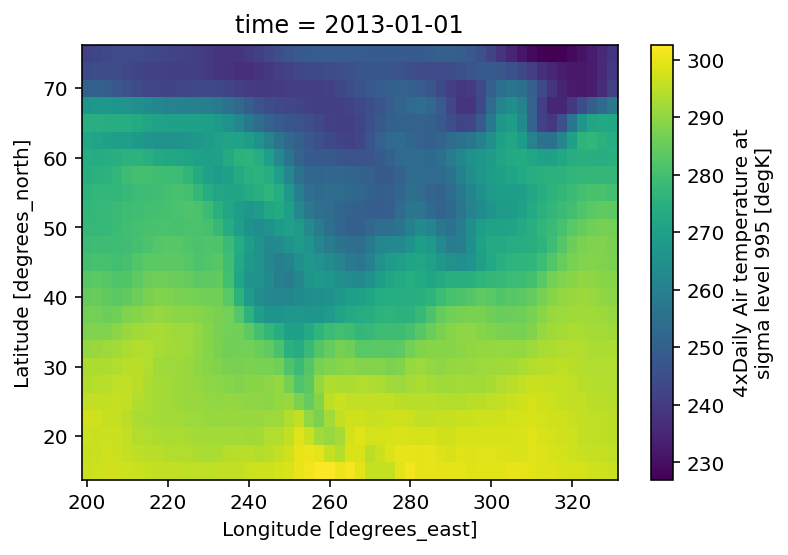

In [55]:
import numpy as np
import xarray as xr
xr.set_options(display_style="text", keep_attrs=True)

da = xr.tutorial.load_dataset("air_temperature").air
monthly = da.resample(time="M").mean()
data = da.isel(time=0)
data.plot()

## Concept: "Index" vs "Label" space operations

Consider `.isel` vs `sel`

In [2]:
# index space
data[10, :]  # 10th element along the first axis; ¯\_(ツ)_/¯

# index space
data.isel(lat=10)  # slightly better, 10th element in latitude

# "label" space
data.sel(lat=50)  # much better! lat=75°N

<xarray.DataArray 'air' (lon: 53)>
array([277.29   , 277.4    , 277.79   , 278.6    , 279.5    , 280.1    ,
       280.6    , 280.9    , 280.79   , 280.69998, 280.79   , 281.     ,
       280.29   , 277.69998, 273.5    , 269.     , 265.5    , 264.     ,
       265.19998, 268.1    , 269.79   , 267.9    , 263.     , 258.1    ,
       254.59999, 251.79999, 249.59999, 249.89   , 252.29999, 254.     ,
       254.29999, 255.89   , 260.     , 263.     , 261.5    , 257.29   ,
       255.5    , 258.29   , 264.     , 268.69998, 270.5    , 270.6    ,
       271.19998, 272.9    , 274.79   , 276.4    , 278.19998, 280.5    ,
       282.9    , 284.69998, 286.1    , 286.9    , 286.6    ],
      dtype=float32)
Coordinates:
    lat      float32 50.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [3]:
# What I wanted to do
data.sel(lat=50)

# What I had to do (if I wasn't using xarray)
data[10, :]

<xarray.DataArray 'air' (lon: 53)>
array([277.29   , 277.4    , 277.79   , 278.6    , 279.5    , 280.1    ,
       280.6    , 280.9    , 280.79   , 280.69998, 280.79   , 281.     ,
       280.29   , 277.69998, 273.5    , 269.     , 265.5    , 264.     ,
       265.19998, 268.1    , 269.79   , 267.9    , 263.     , 258.1    ,
       254.59999, 251.79999, 249.59999, 249.89   , 252.29999, 254.     ,
       254.29999, 255.89   , 260.     , 263.     , 261.5    , 257.29   ,
       255.5    , 258.29   , 264.     , 268.69998, 270.5    , 270.6    ,
       271.19998, 272.9    , 274.79   , 276.4    , 278.19998, 280.5    ,
       282.9    , 284.69998, 286.1    , 286.9    , 286.6    ],
      dtype=float32)
Coordinates:
    lat      float32 50.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## Windowing Operations : index space

These are windowed operations with a window of a fixed size.

- ``rolling``: sliding window operations e.g. running mean
- ``coarsen``: decimating; reshaping

### Sliding windows of fixed length: ``rolling``

- returns object of same shape as input
- pads with NaNs to make this happen
- supports multiple dimensions

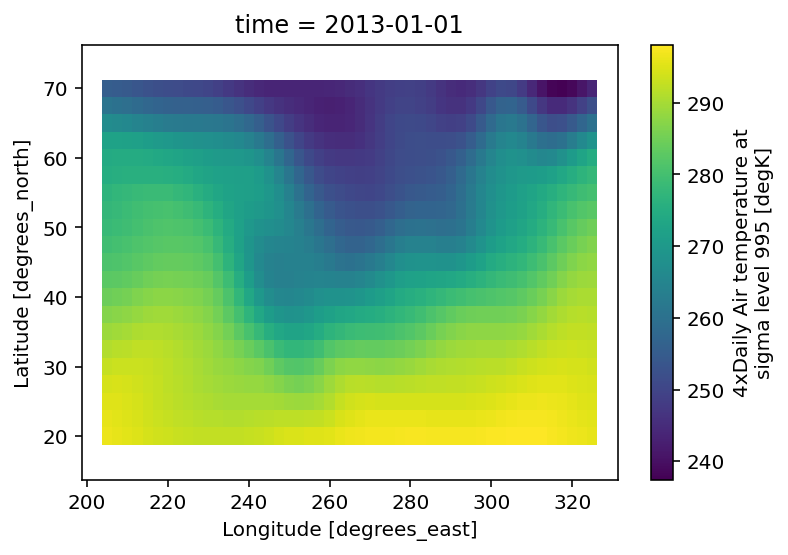

In [4]:
data.rolling(lat=5, lon=5, center=True).mean().plot()

#### Apply an existing numpy-only function with ``reduce``

Here's an example function: `np.ptp`

In [16]:
np.ptp?

Signature: np.ptp(a, axis=None, out=None, keepdims=<no value>)
Docstring:
Range of values (maximum - minimum) along an axis.

The name of the function comes from the acronym for 'peak to peak'.

.. warning::
    `ptp` preserves the data type of the array. This means the
    return value for an input of signed integers with n bits
    (e.g. `np.int8`, `np.int16`, etc) is also a signed integer
    with n bits.  In that case, peak-to-peak values greater than
    ``2**(n-1)-1`` will be returned as negative values. An example
    with a work-around is shown below.

Parameters
----------
a : array_like
    Input values.
axis : None or int or tuple of ints, optional
    Axis along which to find the peaks.  By default, flatten the
    array.  `axis` may be negative, in
    which case it counts from the last to the first axis.

    .. versionadded:: 1.15.0

    If this is a tuple of ints, a reduction is performed on multiple
    axes, instead of a single axis or all the axes as before.
out : ar

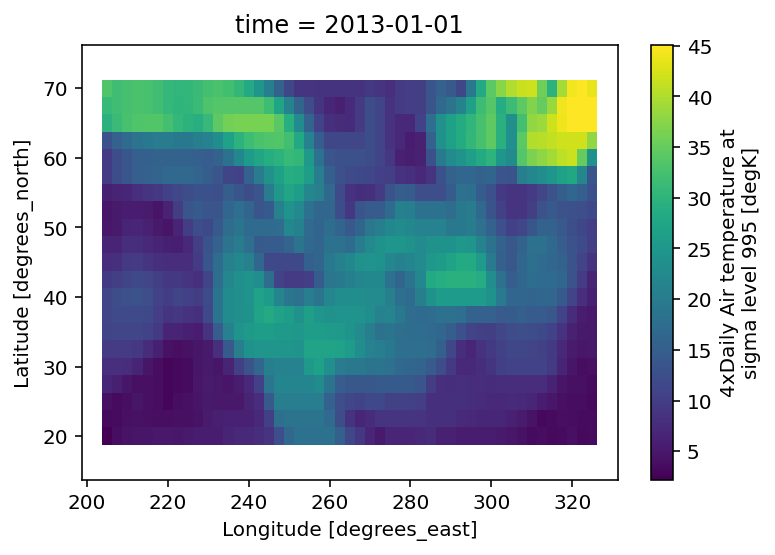

In [5]:
data.rolling(lat=5, lon=5, center=True).reduce(np.ptp).plot()

#### For more complicated analysis, construct a new array with a new dimension.
Allows things like short-time fourier transform, spectrogram, windowed rolling etc.

``construct`` is clever. It constructs a **view** of the original array, so it is memory-efficient
- But you didn't have to know that

In [96]:
simple = xr.DataArray(np.arange(10), dims="time", coords={"time": np.arange(10)})

# adds a new dimension "window"
simple.rolling(time=5, center=True).construct("window")

<xarray.DataArray (time: 10, window: 5)>
array([[nan, nan,  0.,  1.,  2.],
       [nan,  0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.,  4.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 2.,  3.,  4.,  5.,  6.],
       [ 3.,  4.,  5.,  6.,  7.],
       [ 4.,  5.,  6.,  7.,  8.],
       [ 5.,  6.,  7.,  8.,  9.],
       [ 6.,  7.,  8.,  9., nan],
       [ 7.,  8.,  9., nan, nan]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: window

### Another construct example

This is a 2D rolling example; we need to provide two new dimension names

In [7]:
(
    data.rolling(lat=5, lon=5, center=True)
    .construct(lat="lat_roll", lon="lon_roll")
)

<xarray.DataArray 'air' (lat: 25, lon: 53, lat_roll: 5, lon_roll: 5)>
array([[[[      nan,       nan,       nan,       nan,       nan],
         [      nan,       nan,       nan,       nan,       nan],
         [      nan,       nan, 241.2    , 242.5    , 243.5    ],
         [      nan,       nan, 243.79999, 244.5    , 244.7    ],
         [      nan,       nan, 250.     , 249.79999, 248.89   ]],

        [[      nan,       nan,       nan,       nan,       nan],
         [      nan,       nan,       nan,       nan,       nan],
         [      nan, 241.2    , 242.5    , 243.5    , 244.     ],
         [      nan, 243.79999, 244.5    , 244.7    , 244.2    ],
         [      nan, 250.     , 249.79999, 248.89   , 247.5    ]],

        [[      nan,       nan,       nan,       nan,       nan],
         [      nan,       nan,       nan,       nan,       nan],
         [241.2    , 242.5    , 243.5    , 244.     , 244.09999],
         [243.79999, 244.5    , 244.7    , 244.2    , 243.39   ],
         [250.     , 249.79999, 248.89   , 247.5    , 246.     ]],

        ...,

...
        ...,

        [[296.69998, 295.79   , 295.4    , 295.1    , 294.69998],
         [296.9    , 296.29   , 295.9    , 295.9    , 295.19998],
         [297.79   , 297.6    , 296.9    , 296.79   , 296.6    ],
         [      nan,       nan,       nan,       nan,       nan],
         [      nan,       nan,       nan,       nan,       nan]],

        [[295.79   , 295.4    , 295.1    , 294.69998,       nan],
         [296.29   , 295.9    , 295.9    , 295.19998,       nan],
         [297.6    , 296.9    , 296.79   , 296.6    ,       nan],
         [      nan,       nan,       nan,       nan,       nan],
         [      nan,       nan,       nan,       nan,       nan]],

        [[295.4    , 295.1    , 294.69998,       nan,       nan],
         [295.9    , 295.9    , 295.19998,       nan,       nan],
         [296.9    , 296.79   , 296.6    ,       nan,       nan],
         [      nan,       nan,       nan,       nan,       nan],
         [      nan,       nan,       nan,       nan,       nan]]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Dimensions without coordinates: lat_roll, lon_roll
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

### Block windows of fixed length: ``coarsen``

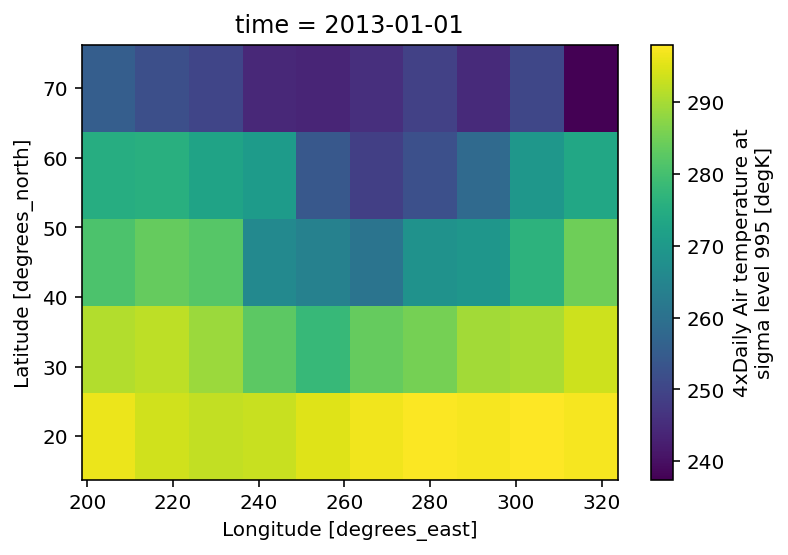

In [8]:
(
    data
    .coarsen(lat=5, lon=5, boundary="trim").mean()
    .plot()
)

#### coarsen supports ``reduce`` for custom reductions

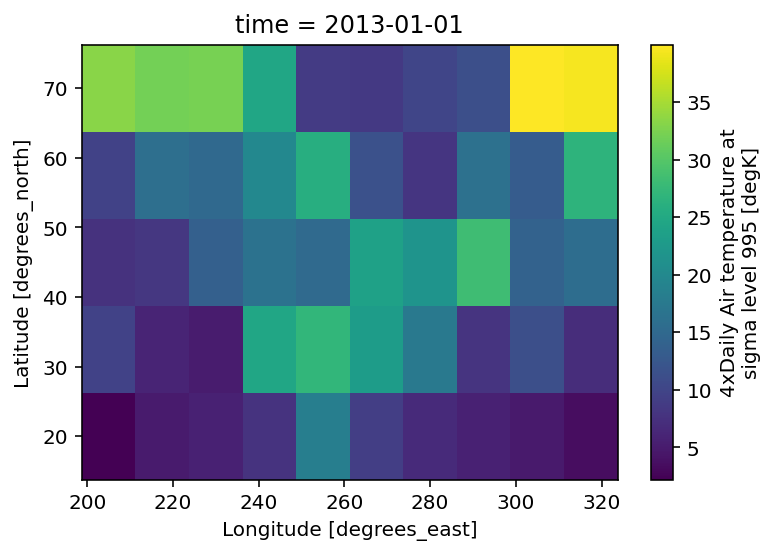

In [9]:
(
    data
    .coarsen(lat=5, lon=5, boundary="trim").reduce(np.ptp)
    .plot()
)

#### coarsen supports ``construct`` for block reshaping

A simple example

In [26]:
months = xr.DataArray(np.tile(np.arange(1, 13), reps=2), dims="time")
months

<xarray.DataArray (time: 24)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12])
Dimensions without coordinates: time

In [27]:
months.coarsen(time=12).construct(time=("year", "month"))

<xarray.DataArray (year: 2, month: 12)>
array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])
Dimensions without coordinates: year, month

In [ ]:
# splits time dimension into year x month
year_month = monthly.coarsen(time=12).construct(time=("year", "month"))
# seasonal cycle for two years
year_month.sel(lon=250).plot.contourf(col="year", x="month", y="lat", robust=True)

## Grouping operations : label space

Generalization of ``coarsen``: sometimes the windows you want are not regular.

- ``groupby``: e.g. climatologies, composites; works when "groups" are exact: e.g. characters or integers; not floats
- ``groupby_bins``: binning operations e.g. histograms
- ``resample``: groupby but specialized for time grouping (so far)


## groupby

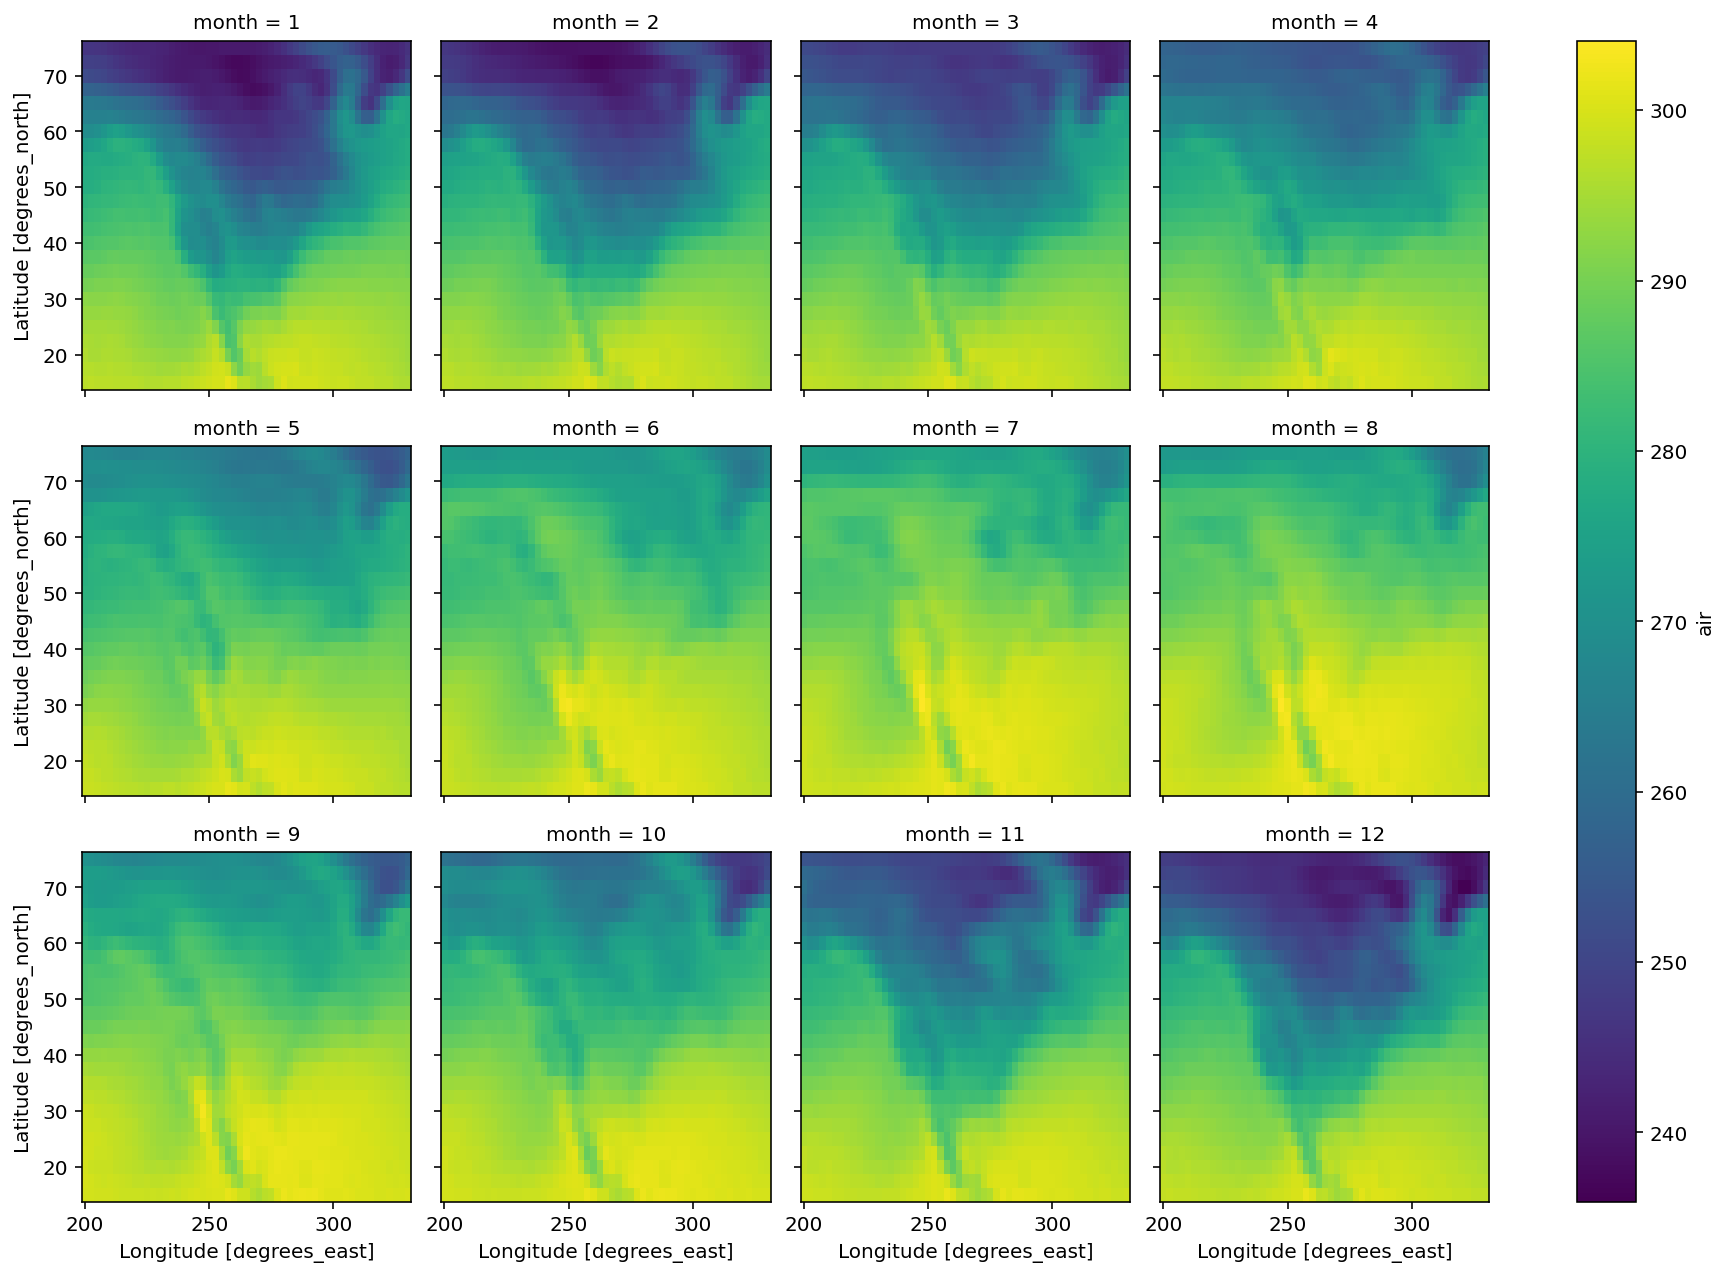

In [15]:
(
    da.groupby("time.month").mean()
    .plot(col="month", col_wrap=4)
)

## groupby_bins

Like groupby but now the groups are bins. Useful for histogramming / grouping by `float` variables

In [32]:
binned = data.groupby_bins("lat", bins=[20, 35, 40, 45, 50])
binned

DataArrayGroupBy, grouped over 'lat_bins'
4 groups with labels (45.0,, 50.0], ..., (20.0,, 35.0].

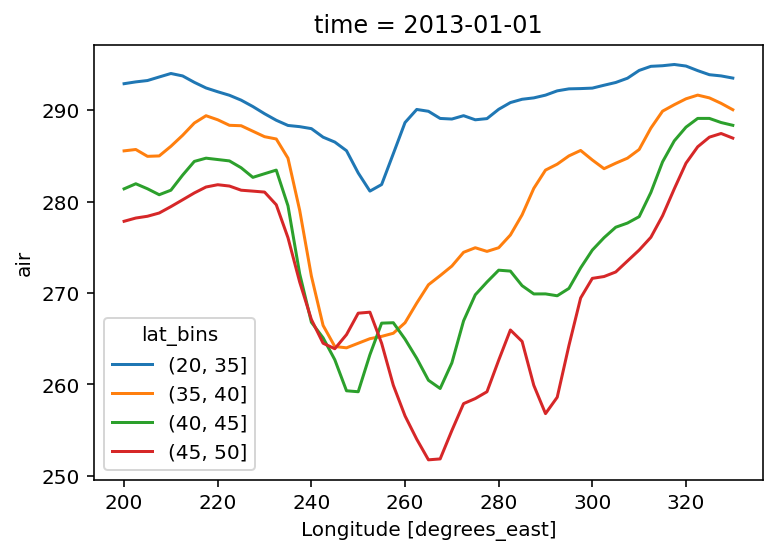

In [34]:
binned.mean().plot.line(hue="lat_bins")

## resample

groupby but specialized for time-grouping to a specified frequency

Simple frequency strings are "D" for Day, "M" for MonthEnd , "A" for Annual etc.

More complicated frequency strings are [available](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases), thanks to Pandas.

All these work with CFTime and Datetime (so all calendars are supported)

In [65]:
da.resample(time="M").mean()

<xarray.DataArray 'air' (time: 24, lat: 25, lon: 53)>
array([[[244.4667 , 244.66354, 244.67027, ..., 242.49142, 243.40633,
         244.67577],
        [247.07323, 247.02248, 246.7275 , ..., 240.58205, 242.04489,
         244.70726],
        [250.37941, 249.83484, 249.10748, ..., 241.98434, 244.76712,
         249.00505],
        ...,
        [295.83795, 295.15085, 294.9229 , ..., 295.36826, 294.88437,
         294.26828],
        [296.46942, 296.31686, 295.84802, ..., 295.5876 , 295.34058,
         294.86536],
        [297.05316, 297.0418 , 296.73517, ..., 296.30438, 296.09732,
         296.0389 ]],

       [[240.73384, 240.7013 , 240.4115 , ..., 241.60518, 242.71988,
         243.94455],
        [241.93309, 242.06935, 241.913  , ..., 241.01428, 242.32481,
         244.72758],
        [245.32361, 245.0261 , 244.36955, ..., 243.41588, 245.7661 ,
         249.65858],
...
        [298.04895, 297.35007, 297.22195, ..., 298.01172, 297.66013,
         297.14554],
        [298.96484, 298.81186, 298.27136, ..., 298.10403, 298.22104,
         297.88547],
        [299.17334, 299.2175 , 298.89566, ..., 298.71625, 298.74167,
         298.7802 ]],

       [[246.80156, 246.88907, 246.76907, ..., 240.07089, 241.08206,
         242.2817 ],
        [247.72998, 248.30064, 248.74443, ..., 238.61859, 240.3222 ,
         242.97026],
        [249.96893, 249.58516, 249.57521, ..., 237.70308, 241.23743,
         246.22667],
        ...,
        [296.4491 , 295.6914 , 295.75824, ..., 296.52817, 296.21747,
         295.8128 ],
        [297.44586, 297.43613, 297.1817 , ..., 296.95242, 297.05823,
         296.72897],
        [298.0472 , 298.22598, 298.0595 , ..., 297.6975 , 297.72318,
         297.71024]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

### groupby supports `reduce` for custom reductions

This applies to `groupby_bins` and `resample`

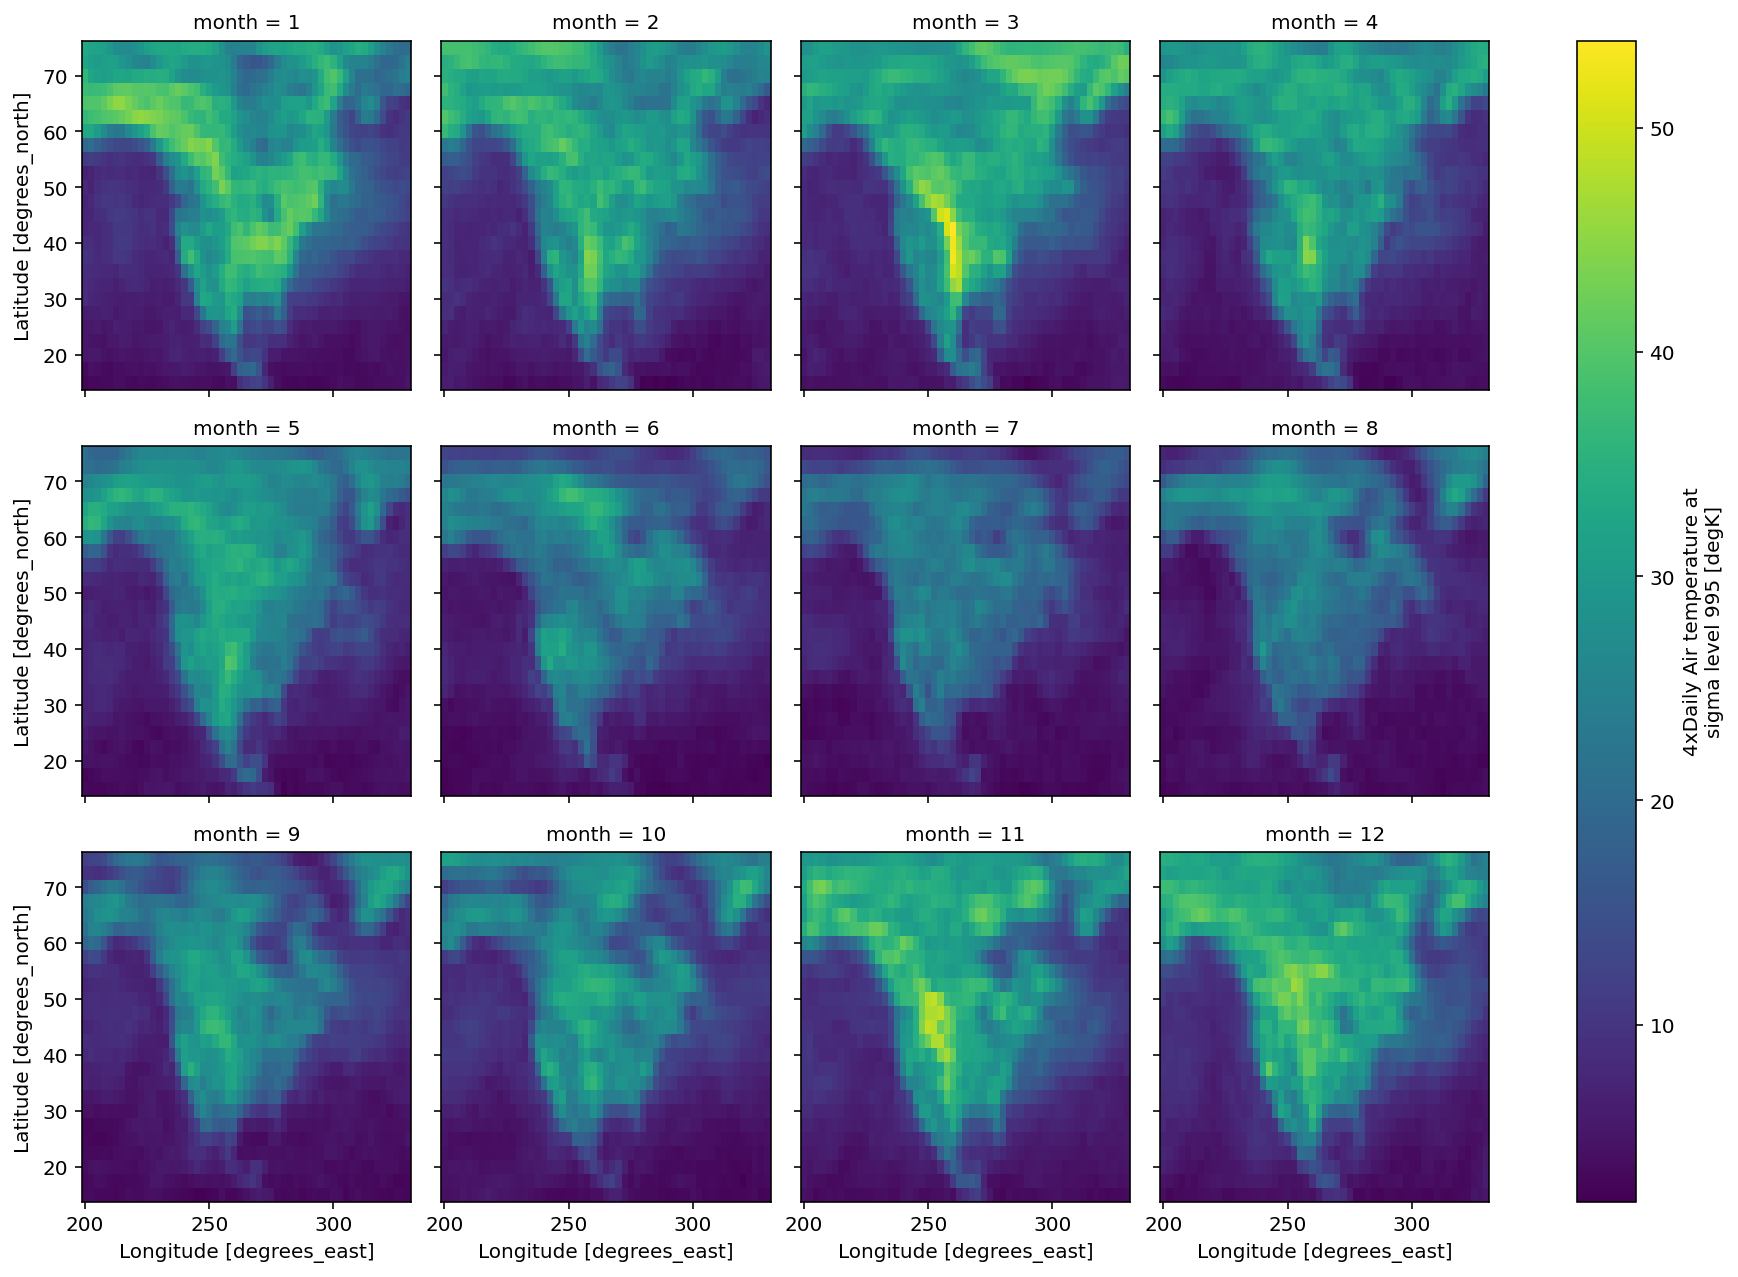

In [57]:
(
    da.groupby("time.month").reduce(np.ptp)
    .plot(col="month", col_wrap=4)
)

### Looping over groupby objects is possible

Maybe you want to plot data in each group separately?

In [68]:
for label, group in da.groupby("time.month"):
    break
    
label

1

This is a DataArray contain data for all January days

In [70]:
group

<xarray.DataArray 'air' (time: 248, lat: 25, lon: 53)>
array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
         235.79999],
        [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
         235.7    ],
        [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
         238.5    ],
...
        [295.5    , 295.     , 294.9    , ..., 294.9    , 293.79   ,
         292.79   ],
        [296.5    , 296.6    , 296.29   , ..., 294.5    , 293.9    ,
         292.9    ],
        [296.69998, 297.     , 297.1    , ..., 295.4    , 295.     ,
         294.5    ]],

       [[260.69998, 260.19998, 259.19998, ..., 245.2    , 244.5    ,
         245.     ],
        [265.29   , 265.5    , 265.5    , ..., 246.2    , 248.09999,
         251.79999],
        [264.4    , 263.5    , 263.4    , ..., 250.2    , 253.59999,
         258.19998],
        ...,
        [296.19998, 295.4    , 295.29   , ..., 294.79   , 293.69998,
         292.79   ],
        [296.69998, 296.6    , 296.29   , ..., 294.79   , 294.     ,
         293.29   ],
        [296.5    , 297.19998, 297.4    , ..., 295.6    , 295.1    ,
         294.79   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-01-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

### In most cases, avoid a for loop using ``map``

Apply functions that expect xarray Datasets or DataArrays.

Avoid having to manually combine results using concat

In [74]:
def iqr(da):
    return da.quantile(q=0.75) - da.quantile(q=0.25)

da.groupby("time.month").map(iqr)

<xarray.DataArray 'air' (month: 12)>
array([35.3999939 , 35.1000061 , 31.09997559, 25.        , 19.59997559,
       15.39001465, 13.70999146, 14.29998779, 19.09997559, 22.59997559,
       29.01000977, 35.61001587])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## Constructing group labels

groupby is really powerful, as long as you have the right group labels for your problem.

These two functions are useful in rare cases.

1. ``numpy.digitize`` (binning)
2. ``pandas.factorize`` supports characters, strings etc.

### More commonly useful are ["datetime components"](https://xarray.pydata.org/en/stable/user-guide/time-series.html#datetime-components)

Accessed using ``DataArray.dt.*``

In [97]:
da.time.dt.day

<xarray.DataArray 'day' (time: 2920)>
array([ 1,  1,  1, ..., 31, 31, 31])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

In [77]:
da.time.dt.month

<xarray.DataArray 'month' (time: 2920)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

In [78]:
da["time.month"]

<xarray.DataArray 'month' (time: 2920)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

### `floor`, `ceil` and `round` time

In [99]:
# remove roundoff error in timestamps
# floor to daily frequency
da.time.dt.floor("D")

<xarray.DataArray 'floor' (time: 2920)>
array(['2013-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000', ...,
       '2014-12-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

### `strftime` can be extremely useful

So useful and so unintuitive that it has its own website: https://strftime.org/

In [102]:
da.time.dt.strftime("%b-%d")

<xarray.DataArray 'strftime' (time: 2920)>
array(['Jan-01', 'Jan-01', 'Jan-01', ..., 'Dec-31', 'Dec-31', 'Dec-31'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00